In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
import sklearn.ensemble
import sklearn.neural_network
import datetime
import numpy as np

import utils

In [2]:
high_management = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
middle_management = [76, 90, 136, 137, 143, 152, 47, 162]

In [3]:
with open("G_communication.pkl", "rb") as f:
    G_communication = pickle.load(f)
    
with open("G_reportsto.pkl", "rb") as f:
    G_reportsto = pickle.load(f)
    
with open("G_both.pkl", "rb") as f:
    G_both = pickle.load(f)

# Main classification func

In [4]:
def classify(G_name, pct_uncover, attr_uncover, clf, num_iterations=50):
    with open(G_name, "rb") as f:
        G = pickle.load(f)

    num_nodes = G.number_of_nodes()
    num_nodes_to_uncover = int(num_nodes * pct_uncover)
    
    nodes_to_uncover = [k for k in sorted(G.nodes, key=lambda item: G.nodes[item][attr_uncover], reverse=True)][:num_nodes_to_uncover]
    
    utils.uncover_nodes(G, nodes_to_uncover)
    utils.set_all_class_node_attrs(G)
    
    df_train, labels_train, df_test, labels_test = utils.create_df(G, nodes_to_uncover)
    
    clf = clf.fit(df_train, labels_train)
    y_predicted = clf.predict(df_test)
    
#     print(utils.count_classification_metrics(labels_test, y_predicted))
#     utils.plot_confusion_matrix(labels_test, y_predicted)
    
    for node, y in zip(df_test.index, y_predicted):
        nx.set_node_attributes(G, {node: {'pred_class': int(y)}})

    something_changed = True
    i = 0
    num_sth_changed = 0
    while num_sth_changed != 3 and i < num_iterations:
        something_changed = False
        
        for node in sorted(df_test.index, key=lambda item: df_test.loc[node, 'betweenness'], reverse=True):
            for source, dest in G.edges(node):
                if source == node:
                    utils.set_node_attribute(G, node, dest)
                elif dest == node:
                    utils.set_node_attribute(G, node, source)
            for i in range(3):
                df_test.loc[node, f'num_{int(i)}'] = G.nodes[node][f'num_{i}']
            y = int(clf.predict([df_test.loc[node]])[0])
            if y != G.nodes[node]['pred_class']:
                something_changed = True
            nx.set_node_attributes(G, {node: {'pred_class': y}})
            
        if something_changed:
            num_sth_changed = 0
        else:
            num_sth_changed += 1
        i += 1
    
    y_true, y_pred = utils.get_y_true_pred(G)
    
#     print(utils.count_classification_metrics(y_true, y_pred))
#     utils.plot_confusion_matrix(y_true, y_pred)
    
    metrics = utils.count_classification_metrics(y_true, y_pred)
    metrics.update({'confusion_matrix': utils.count_confusion_matrix(y_true, y_pred).tolist()})
    
    return metrics



# classify('G_communication.pkl', 0.1, 'betweenness', sklearn.ensemble.AdaBoostClassifier())

In [5]:
def perform_experiments(params, num_experiments=10):
    start = datetime.datetime.now()
    all_results = pd.DataFrame()
    experiment_method_params = utils.get_next_params(params)
    filename = f"results_{str(start).replace(':', '-').replace(' ', '_')}.csv"
    print(filename)
    for method_params in experiment_method_params:
        for _ in range(num_experiments):
#             print(method_params)
            results = classify(*method_params.values())
#             print(results)
            results.update(method_params)
            all_results = all_results.append(results, ignore_index=True)
        all_results.to_csv(filename)
#     print(filename)
    return filename

In [6]:
params = {
    'G': ["G_reportsto.pkl", "G_communication.pkl", "G_both.pkl"],
    'pct_uncover': [0.1, 0.2, 0.3], 
    'attr_uncover': ['betweenness', 'closeness', 'degree', 'eigenvector', 'harmonic', 'load', 'subgraph'], 
    'clf': [sklearn.ensemble.AdaBoostClassifier(), sklearn.ensemble.RandomForestClassifier(), sklearn.neural_network.MLPClassifier()], 
    'num_iterations': [100]
}

# params = {
#     'G': ["G_reportsto.pkl"], 
#     'pct_uncover': [0.1], 
#     'attr_uncover': ['betweenness', 'closeness'], 
#     'clf': [sklearn.ensemble.AdaBoostClassifier()], 
#     'num_iterations': [10]
# }

In [7]:
# %%time

# filename = perform_experiments(params, num_experiments=10)

CPU times: user 2h 29min 34s, sys: 14.2 s, total: 2h 29min 49s

Wall time: 2h 29min 24s

In [18]:
filename = "results_2020-03-28_23-31-14.430428.csv"
results = pd.read_csv(filename)
results = results.drop(columns="num_iterations")
results['clf'] = results['clf'].apply(lambda row: row.split('(')[0])
results = results.sort_values('test_f1_macro', ascending=False)

In [19]:
results.head(50)

,Unnamed: 0,G,attr_uncover,clf,confusion_matrix,pct_uncover,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted,test_precision_macro,test_precision_micro,test_precision_weighted,test_recall_macro,test_recall_micro,test_recall_weighted
428,428,G_reportsto.pkl,betweenness,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
575,575,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
552,552,G_reportsto.pkl,harmonic,RandomForestClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
572,572,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
571,571,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
570,570,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
488,488,G_reportsto.pkl,degree,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
489,489,G_reportsto.pkl,degree,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
425,425,G_reportsto.pkl,betweenness,AdaBoostClassifier,[[119]],0.3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
280,280,G_reportsto.pkl,degree,RandomForestClassifier,"[[132, 0, 0], [0, 2, 0], [0, 0, 2]]",0.2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
results[results['G'] == 'G_reportsto.pkl'].head(10)

,Unnamed: 0,G,attr_uncover,clf,confusion_matrix,pct_uncover,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted,test_precision_macro,test_precision_micro,test_precision_weighted,test_recall_macro,test_recall_micro,test_recall_weighted
428,428,G_reportsto.pkl,betweenness,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
575,575,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
552,552,G_reportsto.pkl,harmonic,RandomForestClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
572,572,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
571,571,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
570,570,G_reportsto.pkl,load,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
488,488,G_reportsto.pkl,degree,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
489,489,G_reportsto.pkl,degree,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
425,425,G_reportsto.pkl,betweenness,AdaBoostClassifier,[[119]],0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
280,280,G_reportsto.pkl,degree,RandomForestClassifier,"[[132, 0, 0], [0, 2, 0], [0, 0, 2]]",0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [21]:
results[results['G'] == 'G_communication.pkl'].head(10)

,Unnamed: 0,G,attr_uncover,clf,confusion_matrix,pct_uncover,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted,test_precision_macro,test_precision_micro,test_precision_weighted,test_recall_macro,test_recall_micro,test_recall_weighted
914,914,G_communication.pkl,degree,RandomForestClassifier,"[[117, 1, 4], [2, 1, 1], [3, 0, 5]]",0.2,0.917910,0.615968,0.917910,0.916252,0.653005,0.917910,0.917910,0.611339,0.917910,0.917910
916,916,G_communication.pkl,degree,RandomForestClassifier,"[[117, 1, 4], [2, 1, 1], [2, 2, 4]]",0.2,0.910448,0.561184,0.910448,0.912285,0.553796,0.910448,0.914347,0.569672,0.910448,0.910448
1093,1093,G_communication.pkl,closeness,RandomForestClassifier,"[[108, 0, 1], [3, 0, 1], [1, 0, 3]]",0.3,0.948718,0.548014,0.948718,0.933338,0.521429,0.948718,0.918864,0.580275,0.948718,0.948718
1035,1035,G_communication.pkl,subgraph,RandomForestClassifier,"[[121, 0, 1], [4, 0, 0], [3, 1, 4]]",0.2,0.932836,0.527795,0.932836,0.918053,0.581771,0.932836,0.908419,0.497268,0.932836,0.932836
960,960,G_communication.pkl,harmonic,AdaBoostClassifier,"[[112, 5, 5], [0, 3, 1], [2, 4, 2]]",0.2,0.873134,0.524718,0.873134,0.890273,0.494152,0.873134,0.916863,0.639344,0.873134,0.873134
961,961,G_communication.pkl,harmonic,AdaBoostClassifier,"[[112, 5, 5], [0, 3, 1], [2, 4, 2]]",0.2,0.873134,0.524718,0.873134,0.890273,0.494152,0.873134,0.916863,0.639344,0.873134,0.873134
900,900,G_communication.pkl,degree,AdaBoostClassifier,"[[112, 5, 5], [0, 3, 1], [2, 4, 2]]",0.2,0.873134,0.524718,0.873134,0.890273,0.494152,0.873134,0.916863,0.639344,0.873134,0.873134
901,901,G_communication.pkl,degree,AdaBoostClassifier,"[[112, 5, 5], [0, 3, 1], [2, 4, 2]]",0.2,0.873134,0.524718,0.873134,0.890273,0.494152,0.873134,0.916863,0.639344,0.873134,0.873134
968,968,G_communication.pkl,harmonic,AdaBoostClassifier,"[[112, 5, 5], [0, 3, 1], [2, 4, 2]]",0.2,0.873134,0.524718,0.873134,0.890273,0.494152,0.873134,0.916863,0.639344,0.873134,0.873134
967,967,G_communication.pkl,harmonic,AdaBoostClassifier,"[[112, 5, 5], [0, 3, 1], [2, 4, 2]]",0.2,0.873134,0.524718,0.873134,0.890273,0.494152,0.873134,0.916863,0.639344,0.873134,0.873134


In [23]:
results[results['G'] == 'G_both.pkl'].head(10)

,Unnamed: 0,G,attr_uncover,clf,confusion_matrix,pct_uncover,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted,test_precision_macro,test_precision_micro,test_precision_weighted,test_recall_macro,test_recall_micro,test_recall_weighted
1596,1596,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1537,1537,G_both.pkl,degree,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1536,1536,G_both.pkl,degree,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1598,1598,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1597,1597,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1591,1591,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1592,1592,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1595,1595,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1599,1599,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294
1593,1593,G_both.pkl,harmonic,AdaBoostClassifier,"[[111, 6, 7], [0, 4, 0], [4, 2, 2]]",0.2,0.860294,0.554721,0.860294,0.875458,0.506924,0.860294,0.902927,0.715054,0.860294,0.860294


In [24]:
def plot_columns(df, columns_to_test, metric):
    for column in columns_to_test:
        if column in ['use_features', 'use_tags', 'clusters','most_common']:
            order = ['true', 'false']
        else:
            order = None
        bar = sns.barplot(x=column, y=metric, order=order,
                          data=df, palette='hls')
        bar.set_xticklabels(bar.get_xticklabels(), rotation=90)
#         bar.set(ylim=(0, 100))
        plt.tight_layout()
#         bar.figure.savefig(f'{PATH_TO_GRAPHICS}/experiments_blogs_posts/{method}_{column}_{metric}_combined.pdf')
        plt.show()

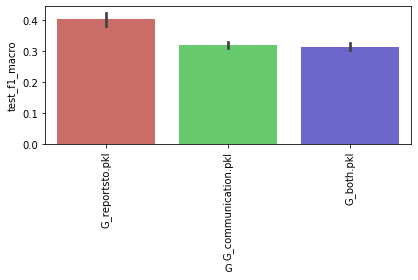

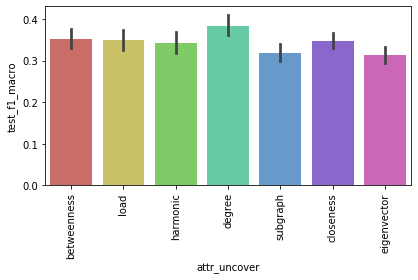

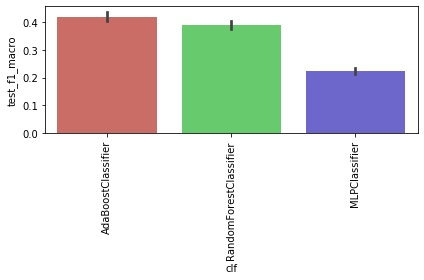

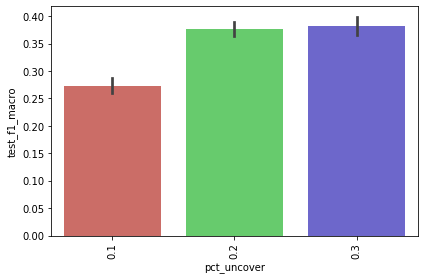

In [25]:
metric = 'test_f1_macro'
columns_to_test = ['G', 'attr_uncover', 'clf', 'pct_uncover']

plot_columns(results, columns_to_test, metric)


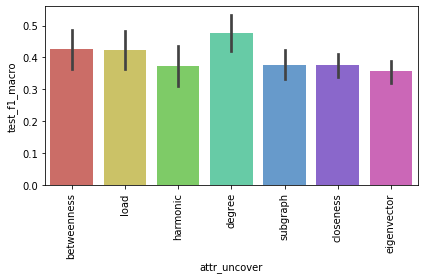

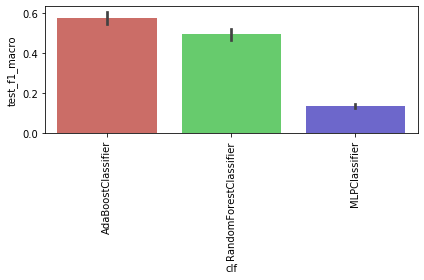

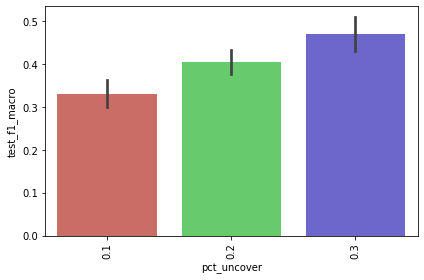

In [26]:
metric = 'test_f1_macro'
columns_to_test = ['attr_uncover', 'clf', 'pct_uncover']

plot_columns(results[results['G'] == 'G_reportsto.pkl'], columns_to_test, metric)


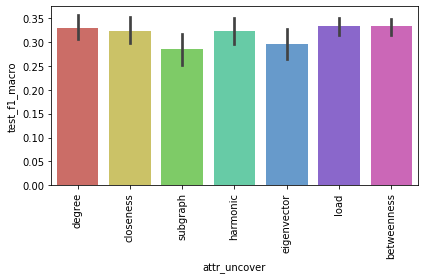

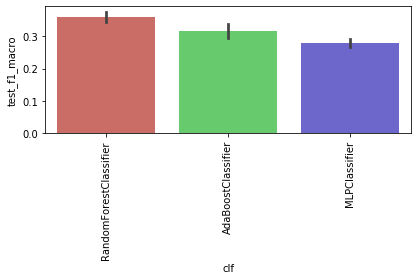

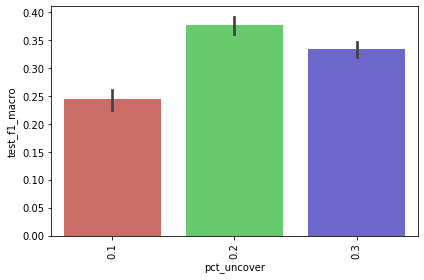

In [27]:
metric = 'test_f1_macro'
columns_to_test = ['attr_uncover', 'clf', 'pct_uncover']

plot_columns(results[results['G'] == 'G_communication.pkl'], columns_to_test, metric)


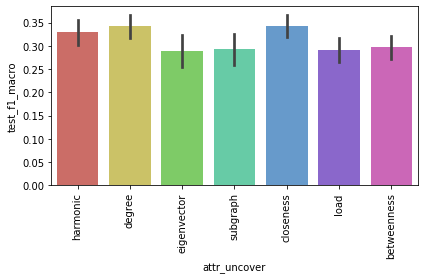

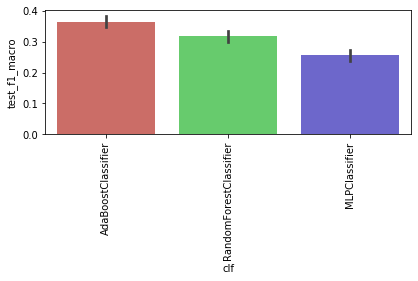

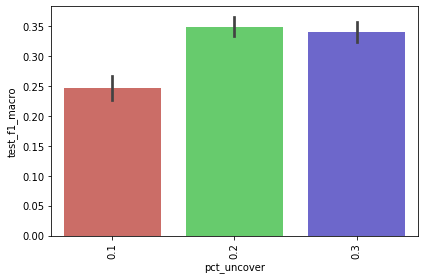

In [28]:
metric = 'test_f1_macro'
columns_to_test = ['attr_uncover', 'clf', 'pct_uncover']

plot_columns(results[results['G'] == 'G_both.pkl'], columns_to_test, metric)


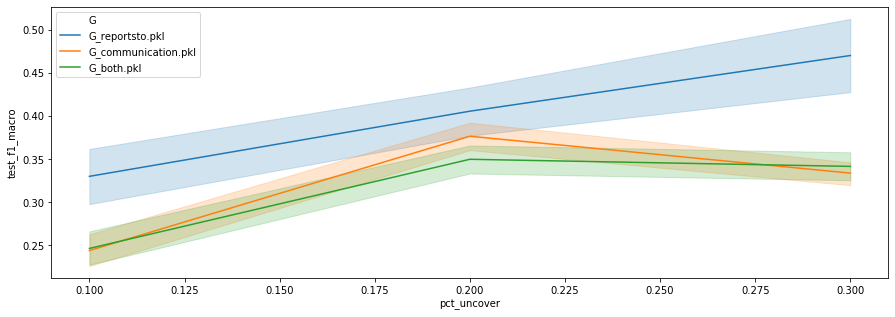

In [58]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=results, x='pct_uncover', y='test_f1_macro', hue='G')

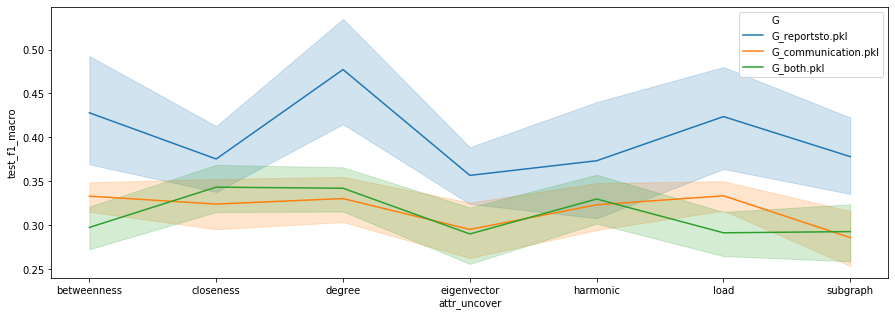

In [57]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=results, x='attr_uncover', y='test_f1_macro', hue='G')

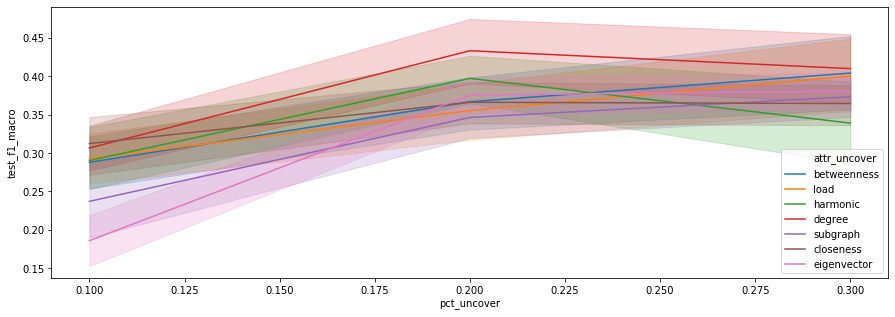

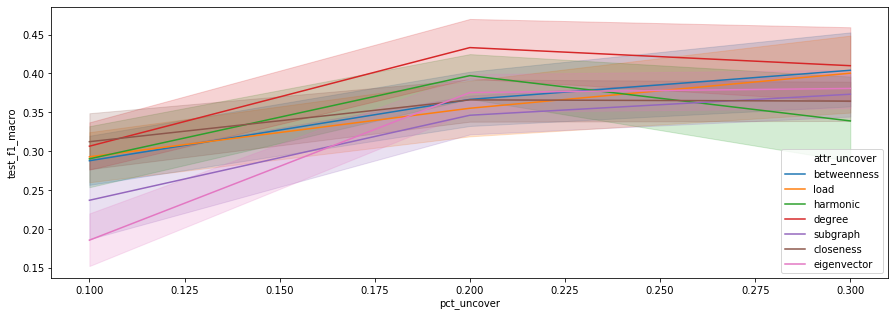

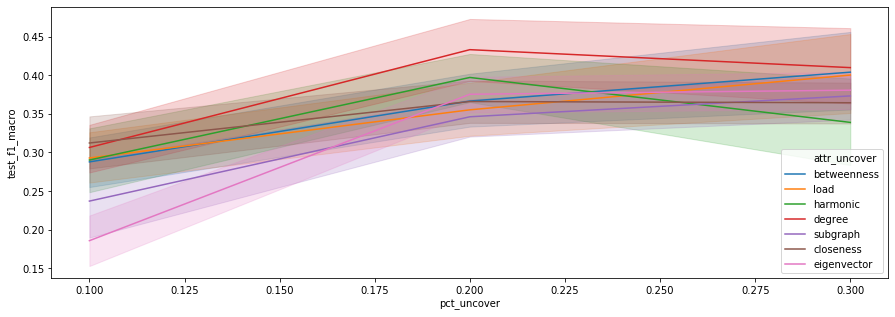

In [54]:
for name, group in results.groupby('G'):
    plt.figure(figsize=(15,5))
    ax = sns.lineplot(data=results, x='pct_uncover', y='test_f1_macro', hue='attr_uncover')
#     ax.set(ylim=(0, 1))
    plt.show()